In [1]:
import cv2
from tkinter import *
from tkinter import ttk
from PIL import Image, ImageTk
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv
import os
from datetime import datetime
import sqlite3
import pickle
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import threading
import time
#removable
import matplotlib.pyplot as plt



In [19]:
#using model to regcognize image
def predict_image(model, image):
    if image:
        test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
        )

        x = []
        x.append(['none', image])
        dftest = pd.DataFrame(x, columns = ["fruit", "path"])

        imtest = test_generator.flow_from_dataframe(
                dataframe=dftest,
                x_col='path',
                y_col='fruit',
                target_size=(224, 224),
                color_mode='rgb',
                class_mode='categorical',
                batch_size=1,
                shuffle=False
            )
        type = ""
        ans = model.predict(imtest)
        ans_label = np.argmax(ans,axis=1)
        label = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'Muskmelon']

        print("The result prediction is:")
        count = 0
        for no in ans_label:
            if(ans[0][ans_label]>0.7):
                type = label[no]
                print(ans[0])
            else:
                type = "not"
                print(ans[0])
            testim = plt.imread(x[count][1])
            plt.imshow(testim)
            plt.title("Original image")
            plt.show()
            count = count + 1
        print(type)
        return type        

In [20]:
#create item object
class item:
    def __init__(self, name, unitPrice, weight):
        self.name = name
        self.unitPrice = unitPrice
        self.weight = weight
        self.price = price
        
    def getPrice(self):
        price = self.unitPrice * self.weight
        return price

In [21]:
#add value to history table database
def addToDatabase(history):
    try:
        sqliteConnection = sqlite3.connect('history.db')
        print("Database created and Successfully Connected to SQLite")
        sql = '''
        INSERT INTO History (ProductName, Weight, Price, Date) 
        VALUES (?, ?, ?, ?)
        '''
        sqliteConnection.execute(sql, history)
        sqliteConnection.commit()
        print ("Records created successfully")
    except sqlite3.Error as error:
        print("Error while connecting to sqlite", error)
    finally:
        if sqliteConnection:
            sqliteConnection.close()
            print("The SQLite connection is closed")

In [22]:
#process with camera
class CaptureObject:
    def __init__(self, video_source):
        self.cap = cv2.VideoCapture(video_source)
        if not self.cap.isOpened():
            raise ValueError("Unable to open video source",video_source)
        self.width = self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        self.height = self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        
    def getFrame(self):
        _, frame = self.cap.read()
        return frame
    
    def releaseVid(self):
        self.cap.release()
           

In [23]:
class MainWindow(Tk):
    def __init__(self, videoSource, model):
        super().__init__()
        # Setting the title of the window
        self.title("App")
        
        # setting attribute
        self.attributes('-fullscreen', True)
        # Bind the ESC key with the callback function
        self.bind('<Escape>', lambda e: self.close_win(e))
                
        #Pretrained model 
        self.model = model
        
        
        #set position of item list
        self.y = 40
        
        #list of item
        self.itemList = []
        self.history = []
        #total price
        self.total = 0
        self.bill = {}

        #set parts for main window
        #left side
        self.leftCanvas = Canvas(self)
        self.leftCanvas.place(relx = 0, rely=0, relwidth = 0.65, relheight = 1)
        #right side
        self.rightCanvas = Canvas(self, bg = "white")
        self.rightCanvas.place(relx = 0.65, rely = 0, relwidth = 0.35, relheight = 1)
        
        #Label in right side
        #name:
        self.name = ttk.Label(self.rightCanvas, text="DATN", font=("", 20), relief="sunken", anchor = CENTER,)
        self.name.place(relx = 0, rely=0, relwidth = 1, relheight = 0.1)
        #list of item label
        self.billCanvas = Canvas(self, bg = "white", borderwidth=1, relief="sunken")
        self.billCanvas.place(relx = 0.65, rely=0.1, relwidth = 0.35, relheight = 0.8)
        ttk.Label(self.billCanvas, text="Type", font=("", 15), anchor = W, background = "white",).place(
            relwidth = 0.3, relx = 0.03 , y = 10)
        ttk.Label(self.billCanvas, text="Unit price", font=("", 15), anchor = CENTER, background = "white",).place(
            relwidth = 0.25, relx = 0.33 , y = 10)
        ttk.Label(self.billCanvas, text="Weight(kg)", font=("", 15), anchor = CENTER, background = "white").place(
            relwidth = 0.19, relx= 0.58 , y = 10)
        ttk.Label(self.billCanvas, text="Price", font=("", 15), anchor = CENTER, background = "white").place(
            relwidth = 0.22, relx= 0.78 , y = 10)
        #total label 
        self.totalLabel = ttk.Label(self, text = "Total: 0 VND", font=("Arial", 30), anchor = CENTER, 
                                    background = "green", foreground = "white")
        self.totalLabel.place(relx = 0.65, rely=0.8, relwidth = 0.35, relheight = 0.2)

        #Label in left size
        #set camera
        self.camHeight = 400
        self.camWidth = 600
        self.webcam = ttk.Label(self)
        self.webcam.place(height=self.camHeight, width=self.camWidth, relx=0.1, rely=0.02)
        self.cap = CaptureObject(videoSource)
        self.show_frames()
        #set button 
        self.scanButton = ttk.Button(self.leftCanvas, text = "Scan", command = self.getValue)
        self.removeButton = ttk.Button(self.leftCanvas, text = "Remove", command = self.destroyLabel)
        self.payButton = ttk.Button(self.leftCanvas, text = "Pay", command = self.showBill)
        #process button to screen
        self.scanButton.place(relx = 0.25, rely=0.6, relwidth = 0.25, relheight = 0.12)
        self.removeButton.place(relx = 0.5, rely=0.6, relwidth = 0.25, relheight = 0.12)
        self.payButton.place(relx = 0.35, rely=0.73, relwidth = 0.3, relheight = 0.15)
        #Wanning line
        self.warningLine = ttk.Label(self.leftCanvas,text="", font=("Arial", 12), foreground = "red", anchor = CENTER)
        self.warningLine.place(relx=0.01, rely=0.5, relwidth = 0.99)


    
    def getWeight(self):
        filename = "weight.txt"
        with open(filename, "r+") as file:
            time.sleep(4)
            weight = 0
            for line in (file.readlines()[-1:]):
                weight = float(line)/1000

            print(weight)
            file.truncate(0)
            file.close()

        return round(weight,2)
        
    #read and show frame from webcam
    def show_frames(self):
        #Get the latest frame and convert into Image
        self.frame = self.cap.getFrame()
        self.frame = cv2.resize(self.frame, (self.camWidth, self.camHeight))
        cv2image= cv2.cvtColor(self.frame ,cv2.COLOR_BGR2RGB)
        img = Image.fromarray(cv2image)
        # Convert image to PhotoImage
        imgtk = ImageTk.PhotoImage(image = img)
        self.webcam.imgtk = imgtk
        self.webcam.configure(image=imgtk)
        # Repeat after an interval to capture continiously
        self.webcam.after(1, self.show_frames)
        
    #Get value from input 
    def getValue(self):
        #get type 
        #save image
        img_name = "opencv_frame.png"
        cv2.imwrite(img_name, self.frame)
        print("{} written!".format(img_name))
        #predict type of fruit
        fType = predict_image(self.model, "opencv_frame.png")
        #remove after predict
        os.remove("opencv_frame.png")
        #get weight
        weight = self.getWeight()
        if fType == "not" or weight < 0.1:
            self.warningLine.config(text = "Invalid item")
            return
        else:
            self.warningLine.config(text = "")
            
            #get price
            price = 0
            unitPrice = 0
            with open("UnitPrices.csv") as file:
                csv_reader = csv.reader(file, delimiter=',')
                a = 0
                for row in csv_reader:
                    if a != 0:
                        if row[0].lower() == fType.lower():
                            price = int(int(row[1])*weight)
                            unitPrice = row[1]
                    a += 1  
            #get current time 
            now = datetime.now()
            dt_string = now.strftime('%d-%m-%y  %H:%M:%S')
            #add to history
            self.history.append((fType, weight, price, dt_string))
            #add to bill
            if fType in self.bill:
                self.bill[fType]["weight"] = float(self.bill[fType]["weight"]) + float(weight)
                self.bill[fType]["price"] = float(self.bill[fType]["price"]) + float(price)
            else:
                self.bill[fType] = {"unitPrice" : unitPrice, "weight" : weight, "price" : price}

            self.addItem(fType, weight, unitPrice, price)

    #show item to he screen
    def addItem(self, fType, weight, unitPrice, price):
        self.y = self.y + 40
        #add item name label
        itemName = Label(self.billCanvas, text = "{}".format(fType), anchor = W, font=("Arial", 18), background = "white")
        itemName.place(relx= 0.03, y=self.y, relwidth = 0.3)
        #add unit price of item label
        itemUnitPrice = Label(self.billCanvas, text = "{:,}".format(int(unitPrice)).replace(',','.'), anchor = CENTER, font=("Arial", 18), background = "white")
        itemUnitPrice.place(relx= 0.33, y=self.y, relwidth = 0.25)
        #add weight of item label
        itemWeight = Label(self.billCanvas, text = "{}".format(weight), anchor = CENTER, font=("Arial", 18), background = "white")
        itemWeight.place(relx= 0.58, y=self.y, relwidth = 0.19)
        #add price of item label
        itemPrice = Label(self.billCanvas, text = "{:,}".format(price), anchor = E, font=("Arial", 18), background = "white")
        itemPrice.place(relx= 0.73, y=self.y, relwidth = 0.25)
        #add item to itemList
        self.itemList.append((itemName, itemUnitPrice, itemWeight, itemPrice))
        #update total
        self.total = self.total + price
        self.totalLabel.config(text = "Total: {:,} VND".format(self.total).replace(',','.'))

        
    #delete current item    
    def destroyLabel(self):
        #only process when item list is not empty
        if self.itemList:
            last = len(self.itemList) - 1
            self.itemList[last][0].destroy()
            self.itemList[last][1].destroy()
            self.itemList[last][2].destroy()
            self.itemList[last][3].destroy()
            self.itemList.pop(last)
            self.y = self.y - 40
            
            fType = self.history[len(self.history)-1][0]
            weight = self.history[len(self.history)-1][1]
            price = self.history[len(self.history)-1][2]
            #change total price
            self.total = self.total - price
            self.totalLabel.config(text = "Total: {:,} VND".format(self.total).replace(',','.'))
            #change bill
            self.bill[fType]["weight"] = float(self.bill[fType]["weight"]) - weight
            self.bill[fType]["price"] = float(self.bill[fType]["price"]) - price
            if self.bill[fType]["price"] == 0:
                self.bill.pop(list(self.bill)[-1])
            #remove from history
            self.history.pop(len(self.history)-1)
    
    #Print out all items in bill and calculate total
    def showBill(self):
        #not run if there is is empty
        if not self.bill:
            return

        #create subwindow
        self.billWindow = Toplevel()
        self.billWindow.title("Bill")
        self.billWindow.resizable(False, False)
        #disable close icon
        def disable_event():
            pass
        self.billWindow.protocol("WM_DELETE_WINDOW", disable_event)
        width = self.billWindow.winfo_width()
        
        #get time 
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%y  %H:%M:%S")
        #time label
        ttk.Label(self.billWindow, text = f"Date: {dt_string}", anchor = W).place(relx=0.1)
        
        #total price
        total = 0

        #position of value label
        y = 40
        
        # Create a canvas widget
        canvas=Canvas(self.billWindow, width=350, height=10)
        canvas.place(y=y-10)
        # Add a line in canvas widget
        canvas.create_line(20,2,330,2, fill="black", width=2)
        #list of item
        ttk.Label(self.billWindow, text="Type", anchor = CENTER).place(relwidth = 0.3, relx=0 , y=y)
        ttk.Label(self.billWindow, text="Unit price", anchor = CENTER).place(relwidth = 0.25, relx=0.3 , y=y)
        ttk.Label(self.billWindow, text="Weight(kg)", anchor = CENTER).place(relwidth = 0.18, relx=0.55 , y=y)
        ttk.Label(self.billWindow, text="Price(VND)", anchor = CENTER).place(relwidth = 0.27, relx=0.73 , y=y)
        # Add labels of value base on number of scan
        for t in self.bill.items():
            y = y + 20
            ftype = t[0]
            unitPrice = int(t[1]["unitPrice"])
            weight = t[1]["weight"]
            price = int(t[1]["price"])
            total = int(total) + price
            #Show Value
            ttk.Label(self.billWindow, text=ftype, anchor = CENTER ).place(relwidth = 0.3, relx=0 , y=y)
            ttk.Label(self.billWindow, text="{:,}".format(unitPrice).replace(',','.'), anchor = CENTER ).place(
                relwidth = 0.25, relx=0.3 , y=y)
            ttk.Label(self.billWindow, text=weight, anchor = CENTER).place(relwidth = 0.18, relx=0.55 , y=y)
            ttk.Label(self.billWindow, text="{:,}".format(price).replace(',','.'), anchor = CENTER).place(
                relwidth = 0.27, relx=0.73 , y=y)
        
        # Create a canvas widget
        canvas=Canvas(self.billWindow, width=350, height=10)
        canvas.place(y=y+20)
        # Add a line in canvas widget
        canvas.create_line(20,2,330,2, fill="black", width=2)
        TotalLabel = ttk.Label(self.billWindow, text="Total: {:,} VND".format(total).replace(',','.'), anchor=CENTER)
        TotalLabel.pack()
        TotalLabel.place(relwidth=width ,y = y+30)
        closeWindowBtn = ttk.Button(self.billWindow, text="Close", command=self.closeBill).pack(side = BOTTOM)

        self.billWindow.geometry(f"350x{y+80}")
        self.payButton.config(state = DISABLED)
        
    #close bill and reset all value
    def closeBill(self):
        self.billWindow.destroy()
        #clear all after view
        self.bill.clear()  
        for i in self.itemList:
            i[0].destroy()
            i[1].destroy()
            i[2].destroy()
            i[3].destroy()
        self.itemList.clear()
        self.y = 40
        #add history to database and clear
        for i in self.history:
            addToDatabase(i)
        self.history.clear()
        #resest total price
        self.total = 0
        self.totalLabel.config(text = "Total: {:,} VND".format(self.total).replace(',','.'))
        self.payButton.config(state = NORMAL)
        
        
            
    #set close events
    def close_win(self, e):
        self.destroy()
        self.cap.releaseVid()
        

opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 4s 4s/step
The result prediction is:
[1.03871105e-04 6.53758718e-07 2.29585240e-09 2.76239036e-12
 9.01324293e-11 3.34626820e-05 7.28477538e-01 8.94541972e-06
 2.27231105e-08 7.27303326e-02 6.24875796e-08 7.94863897e-11
 1.54222056e-04 1.98490828e-01 6.13857551e-08]


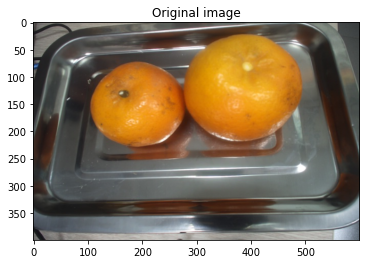

Orange
1.0737
Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed


In [24]:
def main():
    #Load pre-trained model
    X = load_model('mymodel.h5')
    camURL = 0
    #create window
    window = MainWindow(camURL, X)
    window.mainloop()
    
if __name__ == "__main__":
    main()    